In [251]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [252]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [253]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"]
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        # bias = (predictions_df["true"] - np.mean(predictions_df["prediction"], axis=1)) ** 2
        # var = np.var(predictions_df["prediction"], axis=1)

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

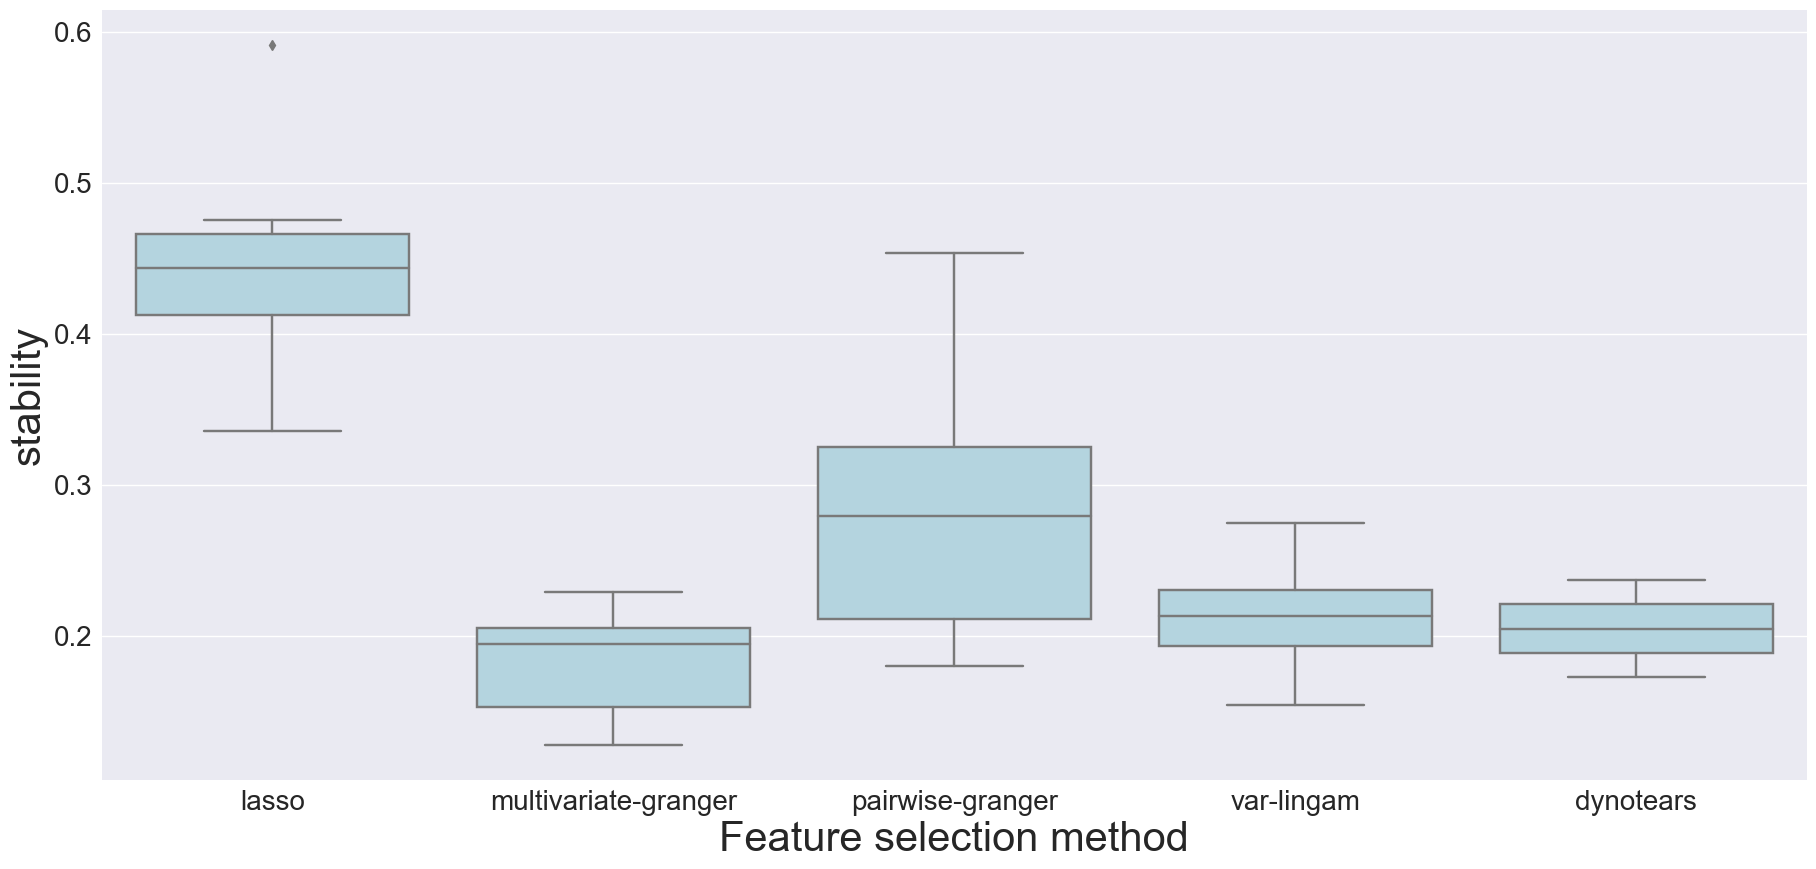

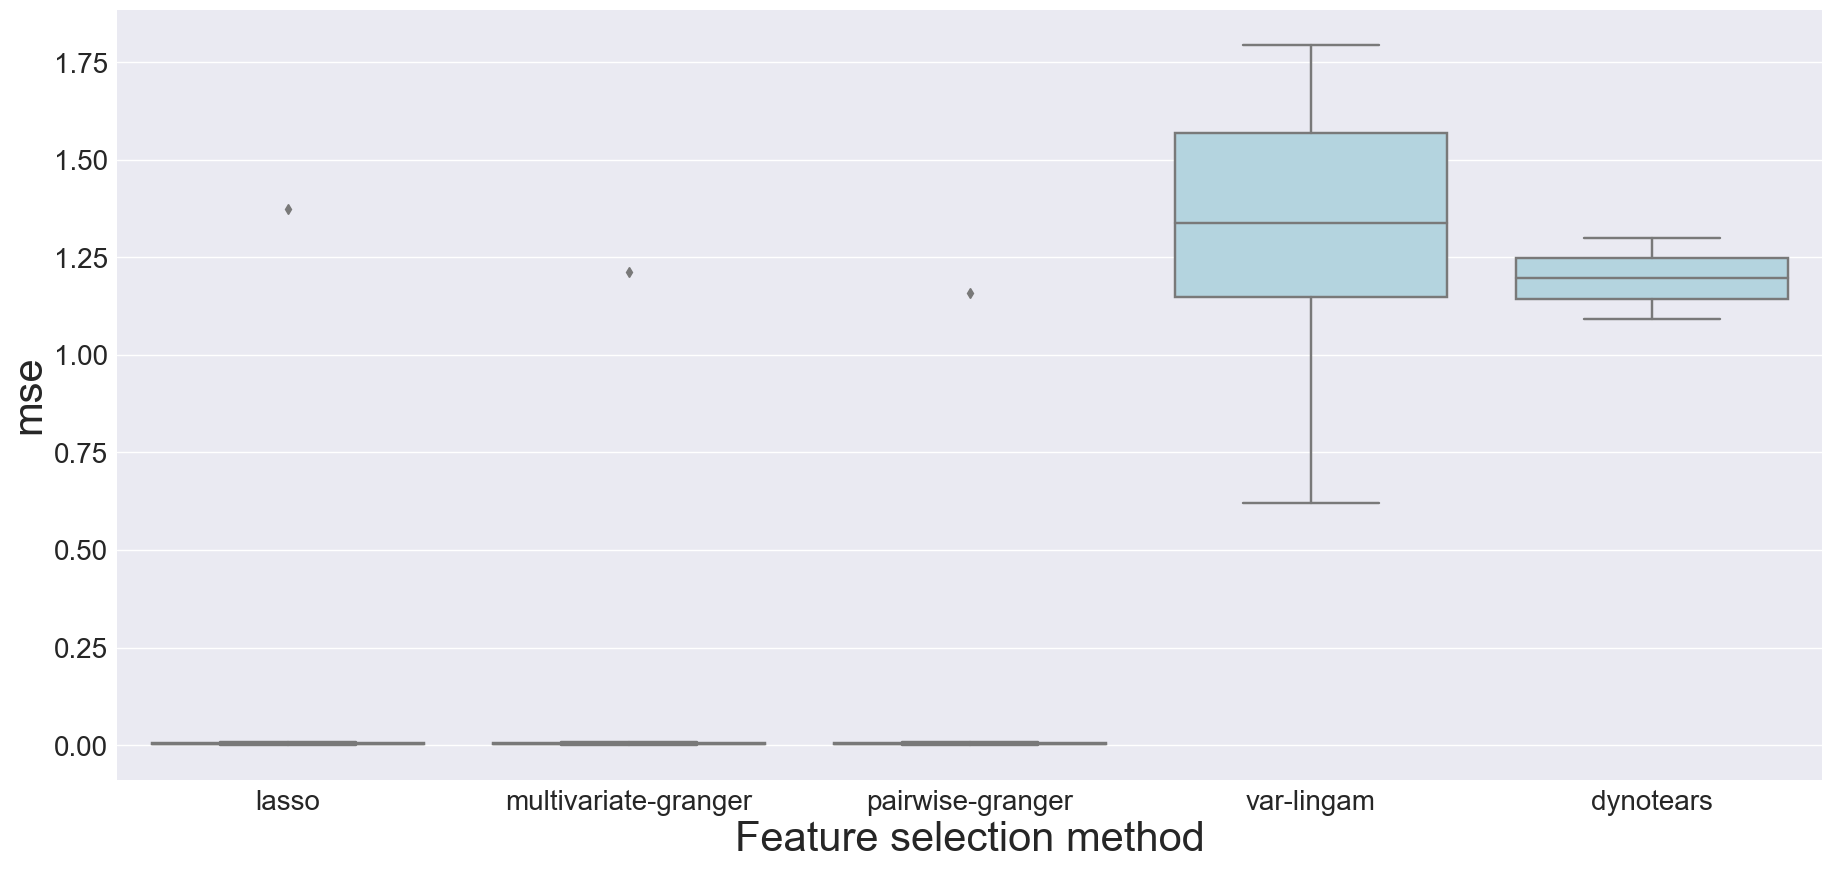

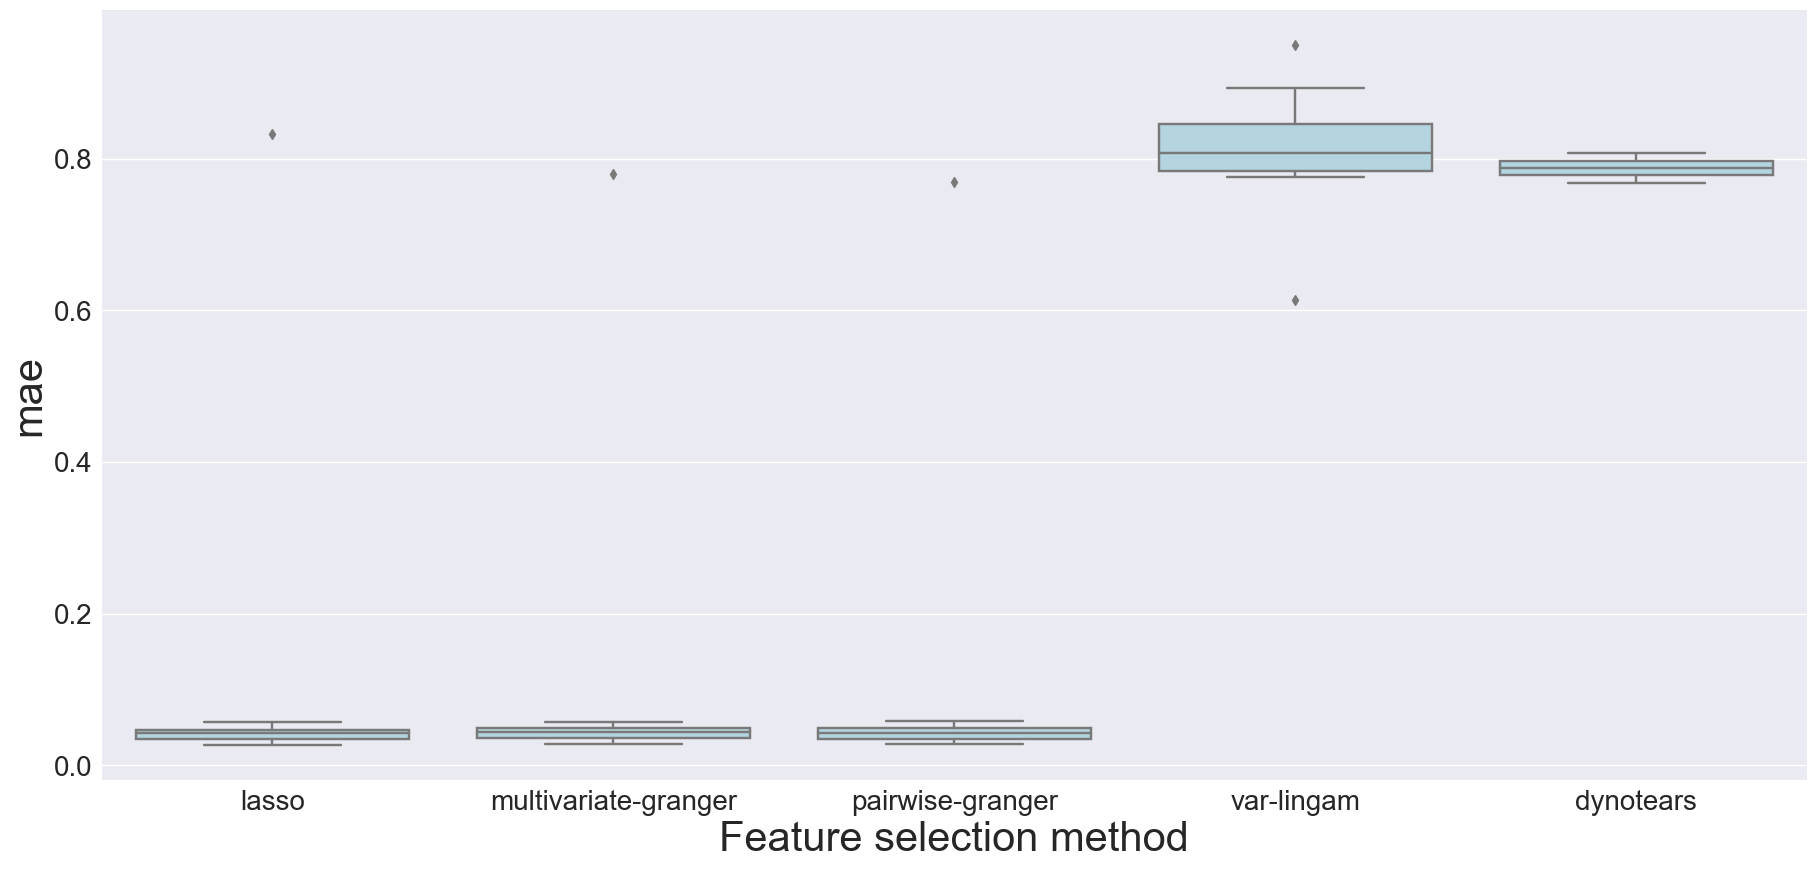

In [254]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

### Prediction error over time

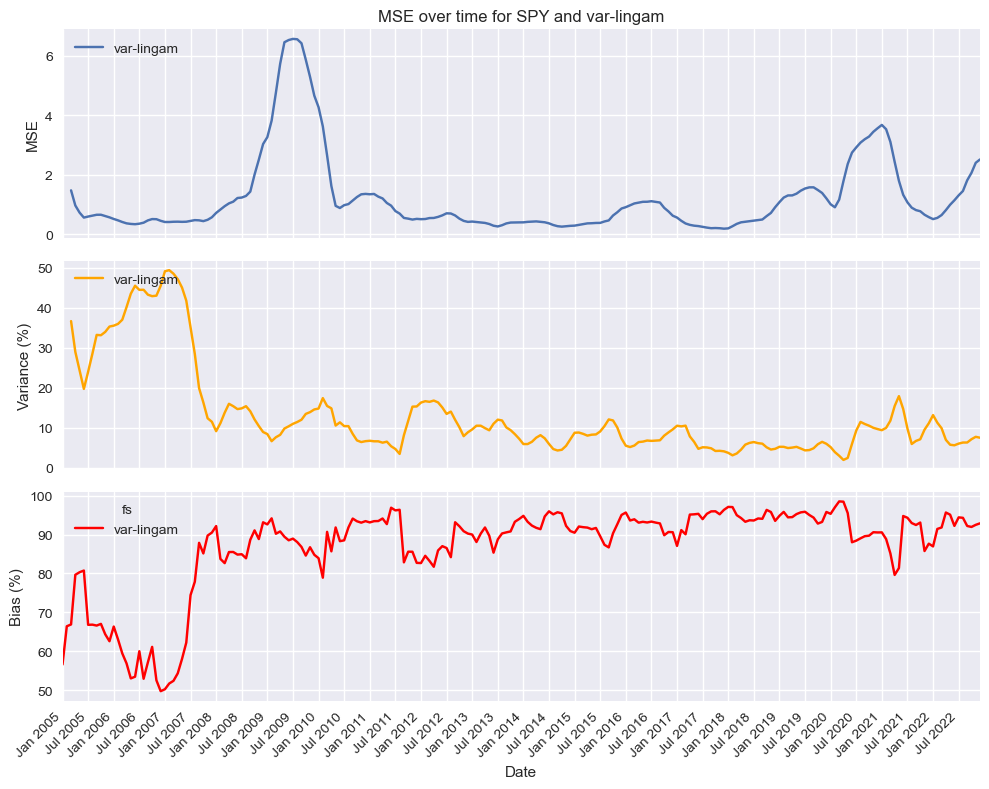

In [255]:
etf = "SPY"
fs = "var-lingam"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

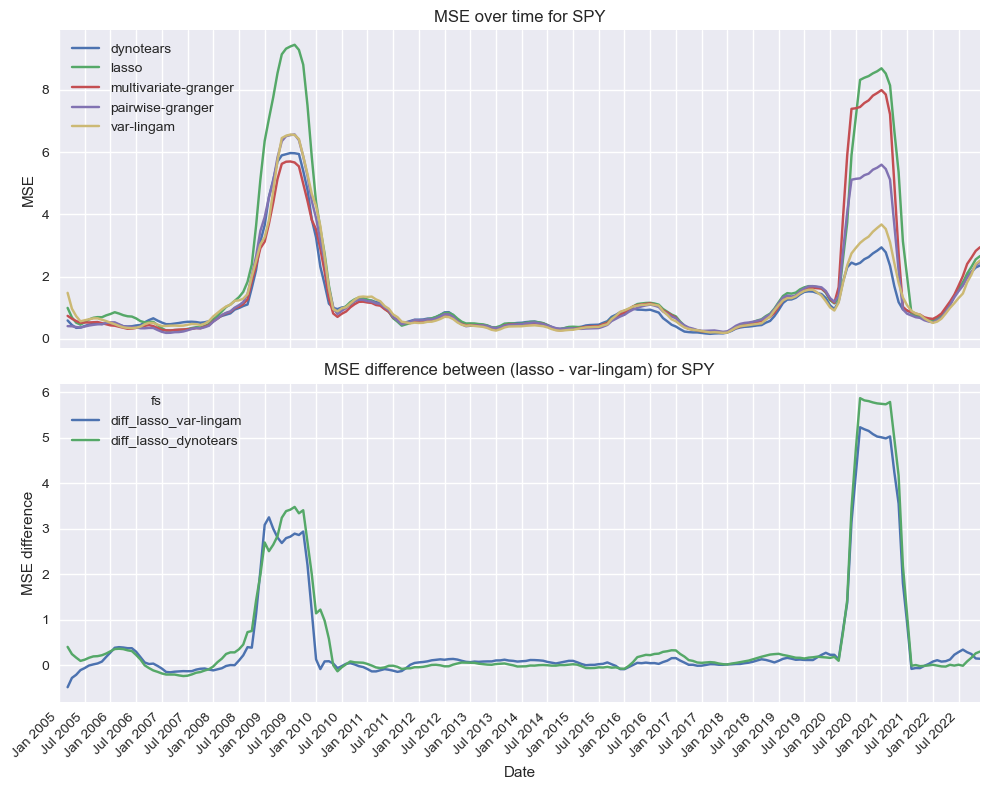

In [277]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in ["SPY"]:# all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["dynotears"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Selected parents over time

In [257]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [258]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                                         \
etf               SPY                                                          
fs         var-lingam                                                          
cluster          0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0   
date                                                                           
2020-01-31        NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
2020-02-29        NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
2020-03-31        NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
2020-04-30        NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   

                                                    
etf                                                 
fs                                                  
cluster    12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0  
date                                                
2020-01-31  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  
2020-02-29  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  
2020-03-31  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  
2020-04-30  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN

In [259]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                               \
etf                         SPY                                                
fs         multivariate-granger                                                
cluster                    1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0   
date                                                                           
2020-01-31                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0   
2020-02-29                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0   
2020-03-31                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
2020-04-30                  1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN   

                                     
etf                                  
fs                                   
cluster    11.0 14.0 16.0 17.0 18.0  
date                                 
2020-01-31  1.0  NaN  NaN  1.0  NaN  
2020-02-29  1.0  NaN  NaN  1.0  NaN  
2020-03-31  1.0  NaN  NaN  1.0  NaN  
2020-04-30  1.0  NaN  NaN  1.0  NaN

## Table of summary statistics

In [260]:
all_metrics_df[all_metrics_df.index.isin(['SPY',], level=1)].sort_values(by="mse", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
dynotears,SPY,1.091840,0.768295,3.179373,1.460585,0.237085
var-lingam,SPY,1.138311,0.781857,3.605335,1.678803,0.227974
pairwise-granger,SPY,1.157833,0.769560,4.418554,1.506459,0.325190
multivariate-granger,SPY,1.213452,0.780146,5.566348,1.653121,0.198788
lasso,SPY,1.373058,0.832697,6.267581,1.960613,0.591410


In [261]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
lasso                XLP  0.001288  0.027338   0.002995  0.045757   0.335825
pairwise-granger     XLP  0.001327  0.027596   0.002620  0.042687   0.180031
multivariate-granger XLP  0.001338  0.027890   0.002623  0.041367   0.127930
                     XLV  0.001905  0.032753   0.006582  0.063924   0.202014
lasso                XLU  0.001922  0.032881   0.003787  0.053058   0.448538
multivariate-granger XLU  0.001924  0.033191   0.004419  0.054524   0.129589
pairwise-granger     XLV  0.001945  0.032785   0.005778  0.058112   0.339608
                     XLU  0.001962  0.033063   0.003411  0.048741   0.185516
lasso                XLV  0.002117  0.033315   0.010153  0.072402   0.466430
pairwise-granger     XLK  0.003089  0.041896   0.012370  0.090935   0.453744
lasso                XLK  0.003208  0.044374   0.007981  0.075665   0.464391
                     XLY  0.003266  0.040764   0.011312  0.078118   0.360866
multivariate-granger XLK  0.003356  0.044773   0.013841  0.099737   0.218950
lasso                XLI  0.003362  0.041706   0.011106  0.082126   0.438851
pairwise-granger     XLY  0.003423  0.041248   0.013209  0.083104   0.324201
multivariate-granger XLY  0.003644  0.042016   0.015664  0.087087   0.206013
pairwise-granger     XLB  0.003735  0.044880   0.010625  0.070326   0.311420
multivariate-granger XLI  0.003754  0.042906   0.016976  0.094930   0.145652
pairwise-granger     XLI  0.003835  0.043840   0.014543  0.083402   0.244543
lasso                XLB  0.003963  0.046273   0.010989  0.078462   0.423304
multivariate-granger XLB  0.004121  0.046053   0.014187  0.083849   0.229141
lasso                XLF  0.004490  0.046720   0.015912  0.094086   0.475556
pairwise-granger     XLF  0.005580  0.050244   0.014253  0.087112   0.200000
multivariate-granger XLF  0.005582  0.050206   0.015469  0.092848   0.174174
lasso                XLE  0.006793  0.057620   0.044678  0.163915   0.408524
multivariate-granger XLE  0.007156  0.056545   0.056570  0.174563   0.190804
pairwise-granger     XLE  0.007418  0.058292   0.056833  0.174319   0.247640
var-lingam           XLK  0.620887  0.613415   2.779891  1.414238   0.154417
dynotears            SPY  1.091840  0.768295   3.179373  1.460585   0.237085
var-lingam           SPY  1.138311  0.781857   3.605335  1.678803   0.227974
                     XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
dynotears            XLI  1.300327  0.806943   5.808571  1.670883   0.172357
lasso                SPY  1.373058  0.832697   6.267581  1.960613   0.591410
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
                     XLI  1.582228  0.840234   8.063200  2.144151   0.211013
                     XLP  1.694379  0.893676  10.914113  2.038251   0.187442
                     XLE  1.795545  0.950434  12.034968  2.884025   0.274519

In [262]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
lasso                XLP  0.001288  0.027338   0.002995  0.045757   0.335825
pairwise-granger     XLP  0.001327  0.027596   0.002620  0.042687   0.180031
multivariate-granger XLP  0.001338  0.027890   0.002623  0.041367   0.127930
                     XLV  0.001905  0.032753   0.006582  0.063924   0.202014
pairwise-granger     XLV  0.001945  0.032785   0.005778  0.058112   0.339608
lasso                XLU  0.001922  0.032881   0.003787  0.053058   0.448538
pairwise-granger     XLU  0.001962  0.033063   0.003411  0.048741   0.185516
multivariate-granger XLU  0.001924  0.033191   0.004419  0.054524   0.129589
lasso                XLV  0.002117  0.033315   0.010153  0.072402   0.466430
                     XLY  0.003266  0.040764   0.011312  0.078118   0.360866
pairwise-granger     XLY  0.003423  0.041248   0.013209  0.083104   0.324201
lasso                XLI  0.003362  0.041706   0.011106  0.082126   0.438851
pairwise-granger     XLK  0.003089  0.041896   0.012370  0.090935   0.453744
multivariate-granger XLY  0.003644  0.042016   0.015664  0.087087   0.206013
                     XLI  0.003754  0.042906   0.016976  0.094930   0.145652
pairwise-granger     XLI  0.003835  0.043840   0.014543  0.083402   0.244543
lasso                XLK  0.003208  0.044374   0.007981  0.075665   0.464391
multivariate-granger XLK  0.003356  0.044773   0.013841  0.099737   0.218950
pairwise-granger     XLB  0.003735  0.044880   0.010625  0.070326   0.311420
multivariate-granger XLB  0.004121  0.046053   0.014187  0.083849   0.229141
lasso                XLB  0.003963  0.046273   0.010989  0.078462   0.423304
                     XLF  0.004490  0.046720   0.015912  0.094086   0.475556
multivariate-granger XLF  0.005582  0.050206   0.015469  0.092848   0.174174
pairwise-granger     XLF  0.005580  0.050244   0.014253  0.087112   0.200000
multivariate-granger XLE  0.007156  0.056545   0.056570  0.174563   0.190804
lasso                XLE  0.006793  0.057620   0.044678  0.163915   0.408524
pairwise-granger     XLE  0.007418  0.058292   0.056833  0.174319   0.247640
var-lingam           XLK  0.620887  0.613415   2.779891  1.414238   0.154417
dynotears            SPY  1.091840  0.768295   3.179373  1.460585   0.237085
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
var-lingam           SPY  1.138311  0.781857   3.605335  1.678803   0.227974
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
                     XLU  1.147135  0.797669   4.193851  1.620898   0.213063
dynotears            XLI  1.300327  0.806943   5.808571  1.670883   0.172357
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
lasso                SPY  1.373058  0.832697   6.267581  1.960613   0.591410
var-lingam           XLI  1.582228  0.840234   8.063200  2.144151   0.211013
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
                     XLP  1.694379  0.893676  10.914113  2.038251   0.187442
                     XLE  1.795545  0.950434  12.034968  2.884025   0.274519

In [263]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
lasso                SPY  1.373058  0.832697   6.267581  1.960613   0.591410
                     XLF  0.004490  0.046720   0.015912  0.094086   0.475556
                     XLV  0.002117  0.033315   0.010153  0.072402   0.466430
                     XLK  0.003208  0.044374   0.007981  0.075665   0.464391
pairwise-granger     XLK  0.003089  0.041896   0.012370  0.090935   0.453744
lasso                XLU  0.001922  0.032881   0.003787  0.053058   0.448538
                     XLI  0.003362  0.041706   0.011106  0.082126   0.438851
                     XLB  0.003963  0.046273   0.010989  0.078462   0.423304
                     XLE  0.006793  0.057620   0.044678  0.163915   0.408524
                     XLY  0.003266  0.040764   0.011312  0.078118   0.360866
pairwise-granger     XLV  0.001945  0.032785   0.005778  0.058112   0.339608
lasso                XLP  0.001288  0.027338   0.002995  0.045757   0.335825
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
                     XLY  0.003423  0.041248   0.013209  0.083104   0.324201
                     XLB  0.003735  0.044880   0.010625  0.070326   0.311420
var-lingam           XLE  1.795545  0.950434  12.034968  2.884025   0.274519
pairwise-granger     XLE  0.007418  0.058292   0.056833  0.174319   0.247640
                     XLI  0.003835  0.043840   0.014543  0.083402   0.244543
dynotears            SPY  1.091840  0.768295   3.179373  1.460585   0.237085
var-lingam           XLV  1.148636  0.792043   3.168952  1.344058   0.231498
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
multivariate-granger XLB  0.004121  0.046053   0.014187  0.083849   0.229141
var-lingam           SPY  1.138311  0.781857   3.605335  1.678803   0.227974
multivariate-granger XLK  0.003356  0.044773   0.013841  0.099737   0.218950
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
                     XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLI  1.582228  0.840234   8.063200  2.144151   0.211013
multivariate-granger XLY  0.003644  0.042016   0.015664  0.087087   0.206013
                     XLV  0.001905  0.032753   0.006582  0.063924   0.202014
pairwise-granger     XLF  0.005580  0.050244   0.014253  0.087112   0.200000
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
                     XLE  0.007156  0.056545   0.056570  0.174563   0.190804
var-lingam           XLP  1.694379  0.893676  10.914113  2.038251   0.187442
pairwise-granger     XLU  0.001962  0.033063   0.003411  0.048741   0.185516
                     XLP  0.001327  0.027596   0.002620  0.042687   0.180031
multivariate-granger XLF  0.005582  0.050206   0.015469  0.092848   0.174174
dynotears            XLI  1.300327  0.806943   5.808571  1.670883   0.172357
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLK  0.620887  0.613415   2.779891  1.414238   0.154417
multivariate-granger XLI  0.003754  0.042906   0.016976  0.094930   0.145652
                     XLU  0.001924  0.033191   0.004419  0.054524   0.129589
                     XLP  0.001338  0.027890   0.002623  0.041367   0.127930

In [264]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
pairwise-granger,XLP,0.001327,0.027596,0.002620,0.042687,0.180031
multivariate-granger,XLP,0.001338,0.027890,0.002623,0.041367,0.127930
lasso,XLP,0.001288,0.027338,0.002995,0.045757,0.335825
pairwise-granger,XLU,0.001962,0.033063,0.003411,0.048741,0.185516
lasso,XLU,0.001922,0.032881,0.003787,0.053058,0.448538
multivariate-granger,XLU,0.001924,0.033191,0.004419,0.054524,0.129589
pairwise-granger,XLV,0.001945,0.032785,0.005778,0.058112,0.339608
multivariate-granger,XLV,0.001905,0.032753,0.006582,0.063924,0.202014
lasso,XLK,0.003208,0.044374,0.007981,0.075665,0.464391


In [265]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae   mse_2020  mae_2020  stability
fs                   etf                                                    
lasso                XLP  0.001288  0.027338   0.002995  0.045757   0.335825
pairwise-granger     XLP  0.001327  0.027596   0.002620  0.042687   0.180031
multivariate-granger XLP  0.001338  0.027890   0.002623  0.041367   0.127930
                     XLV  0.001905  0.032753   0.006582  0.063924   0.202014
lasso                XLU  0.001922  0.032881   0.003787  0.053058   0.448538
multivariate-granger XLU  0.001924  0.033191   0.004419  0.054524   0.129589
pairwise-granger     XLV  0.001945  0.032785   0.005778  0.058112   0.339608
                     XLU  0.001962  0.033063   0.003411  0.048741   0.185516
lasso                XLV  0.002117  0.033315   0.010153  0.072402   0.466430
pairwise-granger     XLK  0.003089  0.041896   0.012370  0.090935   0.453744
lasso                XLK  0.003208  0.044374   0.007981  0.075665   0.464391
                     XLY  0.003266  0.040764   0.011312  0.078118   0.360866
multivariate-granger XLK  0.003356  0.044773   0.013841  0.099737   0.218950
lasso                XLI  0.003362  0.041706   0.011106  0.082126   0.438851
pairwise-granger     XLY  0.003423  0.041248   0.013209  0.083104   0.324201
multivariate-granger XLY  0.003644  0.042016   0.015664  0.087087   0.206013
pairwise-granger     XLB  0.003735  0.044880   0.010625  0.070326   0.311420
multivariate-granger XLI  0.003754  0.042906   0.016976  0.094930   0.145652
pairwise-granger     XLI  0.003835  0.043840   0.014543  0.083402   0.244543
lasso                XLB  0.003963  0.046273   0.010989  0.078462   0.423304
multivariate-granger XLB  0.004121  0.046053   0.014187  0.083849   0.229141
lasso                XLF  0.004490  0.046720   0.015912  0.094086   0.475556
pairwise-granger     XLF  0.005580  0.050244   0.014253  0.087112   0.200000
multivariate-granger XLF  0.005582  0.050206   0.015469  0.092848   0.174174
lasso                XLE  0.006793  0.057620   0.044678  0.163915   0.408524
multivariate-granger XLE  0.007156  0.056545   0.056570  0.174563   0.190804
pairwise-granger     XLE  0.007418  0.058292   0.056833  0.174319   0.247640
var-lingam           XLK  0.620887  0.613415   2.779891  1.414238   0.154417
dynotears            SPY  1.091840  0.768295   3.179373  1.460585   0.237085
var-lingam           SPY  1.138311  0.781857   3.605335  1.678803   0.227974
                     XLU  1.147135  0.797669   4.193851  1.620898   0.213063
                     XLV  1.148636  0.792043   3.168952  1.344058   0.231498
pairwise-granger     SPY  1.157833  0.769560   4.418554  1.506459   0.325190
var-lingam           XLB  1.194002  0.776230   4.204922  1.437719   0.213436
multivariate-granger SPY  1.213452  0.780146   5.566348  1.653121   0.198788
dynotears            XLI  1.300327  0.806943   5.808571  1.670883   0.172357
lasso                SPY  1.373058  0.832697   6.267581  1.960613   0.591410
var-lingam           XLF  1.480025  0.816845   3.432046  1.408405   0.165000
                     XLY  1.525045  0.848040   8.400505  2.070190   0.231333
                     XLI  1.582228  0.840234   8.063200  2.144151   0.211013
                     XLP  1.694379  0.893676  10.914113  2.038251   0.187442
                     XLE  1.795545  0.950434  12.034968  2.884025   0.274519

<AxesSubplot:xlabel='stability', ylabel='mae'>

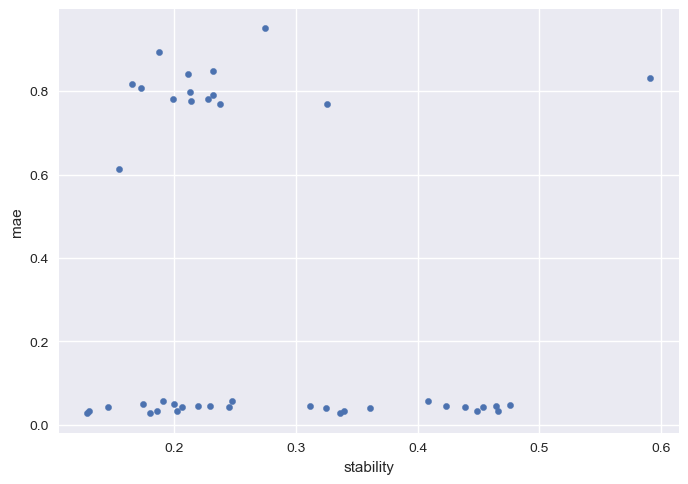

In [266]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

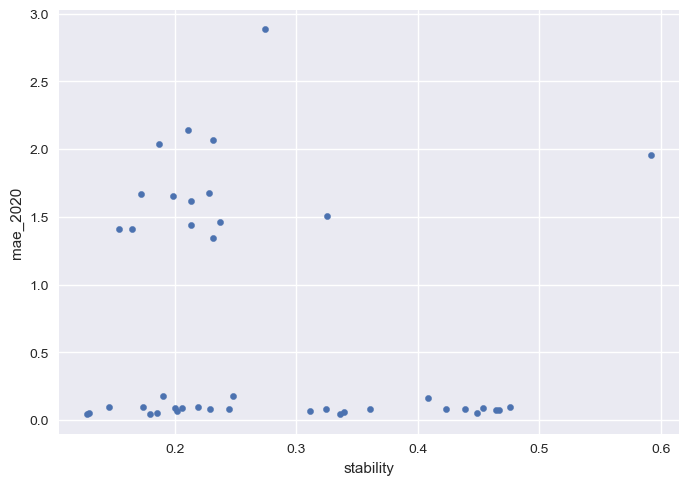

In [267]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

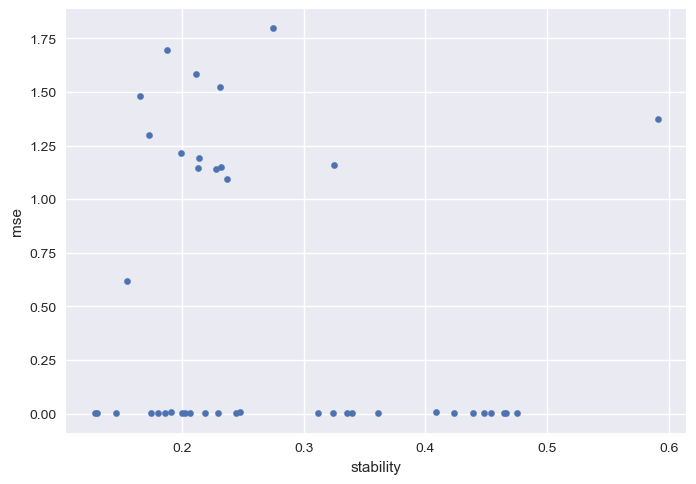

In [268]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

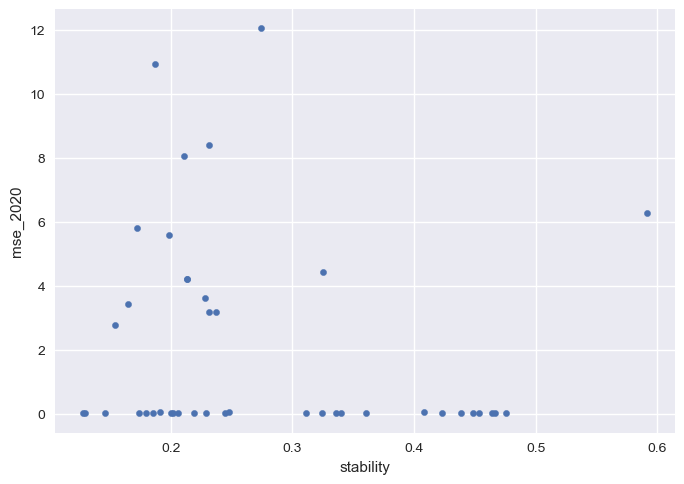

In [269]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")